In [1]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


In [2]:
mask = ((ppmi_ad.obs['Age_Group'] == '70-80') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [3]:
ppmi_ad = ppmi_ad[mask]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    chi2
)
from skfeature.function.similarity_based import fisher_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

In [5]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [6]:
var_selector = VarianceThreshold(threshold=0.1)
X_highvar = var_selector.fit_transform(X)
selected_genes = X.columns[var_selector.get_support()]
print(f"After variance threshold: {len(selected_genes)} genes remaining")

After variance threshold: 56348 genes remaining


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_highvar)

In [8]:
n_top_genes = 20000

### Anova F-Value

In [9]:
anova_scores, _ = f_classif(X_scaled, y)
top_indices_anovaf = np.argsort(anova_scores)[-n_top_genes:][::-1]
anova_selected_genes = selected_genes[top_indices_anovaf]
anova_selected_genes

Index(['ENSG00000263908.1', 'ENSG00000200279.1', 'ENSG00000262898.1',
       'ENSG00000274458.1', 'ENSG00000221059.1', 'ENSG00000184385.2',
       'ENSG00000236713.1', 'ENSG00000272954.1', 'ENSG00000215559.8',
       'ENSG00000268433.1',
       ...
       'ENSG00000233205.1', 'ENSG00000204279.7', 'ENSG00000270165.1',
       'ENSG00000213234.4', 'ENSG00000234050.1', 'ENSG00000215869.4',
       'ENSG00000280366.1', 'ENSG00000101349.16', 'ENSG00000255036.6',
       'ENSG00000165219.21'],
      dtype='object', length=20000)

### Chi-Squared

In [10]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_processed = discretizer.fit_transform(X_scaled)
chi2_scores, _ = chi2(X_processed, y)
top_indices_chi2 = np.argsort(chi2_scores)[-n_top_genes:][::-1]
chi2_selected_genes = selected_genes[top_indices_chi2]
chi2_selected_genes

Index(['ENSG00000200279.1', 'ENSG00000260335.1', 'ENSG00000221059.1',
       'ENSG00000243581.1', 'ENSG00000196826.7', 'ENSG00000251991.1',
       'ENSG00000201016.1', 'ENSG00000283580.3', 'ENSG00000267563.1',
       'ENSG00000261111.1',
       ...
       'ENSG00000187824.8', 'ENSG00000211968.3', 'ENSG00000168772.10',
       'ENSG00000226781.1', 'ENSG00000236439.4', 'ENSG00000259423.2',
       'ENSG00000240912.1', 'ENSG00000111780.8', 'ENSG00000105227.14',
       'ENSG00000219607.3'],
      dtype='object', length=20000)

### Mutual Information

In [11]:
mutual_info_scores = mutual_info_classif(X_scaled, y)
top_indices_mutual_info = np.argsort(mutual_info_scores)[-n_top_genes:][::-1]
mutual_info_selected_genes = selected_genes[top_indices_mutual_info]
mutual_info_selected_genes

Index(['ENSG00000064393.15', 'ENSG00000239532.1', 'ENSG00000273056.1',
       'ENSG00000142025.15', 'ENSG00000239255.1', 'ENSG00000266754.2',
       'ENSG00000233542.1', 'ENSG00000248455.5', 'ENSG00000253448.1',
       'ENSG00000238584.1',
       ...
       'ENSG00000273988.1', 'ENSG00000236173.1', 'ENSG00000196367.13',
       'ENSG00000228948.2', 'ENSG00000275223.1', 'ENSG00000267652.1',
       'ENSG00000258765.1', 'ENSG00000166451.13', 'ENSG00000241354.2',
       'ENSG00000014914.20'],
      dtype='object', length=20000)

### Fisher's Score

In [12]:
from skfeature.function.similarity_based import fisher_score
fisher_score = fisher_score.fisher_score(X_scaled, np.asarray(y))
top_indices_fisher = np.argsort(fisher_score)[-n_top_genes:][::-1]
fisher_selected_genes = selected_genes[top_indices_fisher]
fisher_selected_genes

Index(['ENSG00000283757.1', 'ENSG00000100867.14', 'ENSG00000103512.14',
       'ENSG00000202269.1', 'ENSG00000026652.13', 'ENSG00000230798.5',
       'ENSG00000186952.14', 'ENSG00000229528.1', 'ENSG00000229357.1',
       'ENSG00000233882.2',
       ...
       'ENSG00000128595.16', 'ENSG00000279447.1', 'ENSG00000223393.1',
       'ENSG00000259470.2', 'ENSG00000183166.10', 'ENSG00000244652.1',
       'ENSG00000179796.12', 'ENSG00000263872.1', 'ENSG00000234177.5',
       'ENSG00000270962.1'],
      dtype='object', length=20000)

### Overlapping Genes

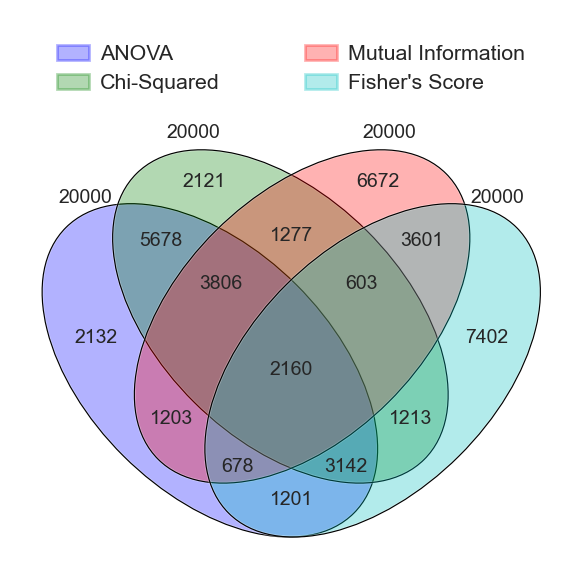

In [13]:
from venny4py.venny4py import *

sets = {
    'ANOVA': set(anova_selected_genes),
    'Chi-Squared': set(chi2_selected_genes),
    'Mutual Information': set(mutual_info_selected_genes),
    'Fisher\'s Score': set(fisher_selected_genes)
}
venny4py(sets=sets)


In [14]:
common_genes = set(anova_selected_genes) & set(chi2_selected_genes) & set(mutual_info_selected_genes) & set(fisher_selected_genes)
print(f"Number of common genes across methods: {len(common_genes)}")
print("Common genes:")
print(common_genes)

Number of common genes across methods: 2160
Common genes:
{'ENSG00000257254.1', 'ENSG00000248161.5', 'ENSG00000268756.1', 'ENSG00000279134.1', 'ENSG00000168490.13', 'ENSG00000207696.1', 'ENSG00000277882.1', 'ENSG00000120075.5', 'ENSG00000249007.1', 'ENSG00000259461.1', 'ENSG00000268945.1', 'ENSG00000203923.4', 'ENSG00000275785.1', 'ENSG00000238103.4', 'ENSG00000137080.4', 'ENSG00000178055.11', 'ENSG00000256400.1', 'ENSG00000283598.1', 'ENSG00000274584.1', 'ENSG00000140479.16', 'ENSG00000174912.7', 'ENSG00000207637.1', 'ENSG00000235304.1', 'ENSG00000231561.2', 'ENSG00000180610.10', 'ENSG00000140992.18', 'ENSG00000242828.1', 'ENSG00000156564.8', 'ENSG00000263670.1', 'ENSG00000250406.1', 'ENSG00000188856.6', 'ENSG00000264435.1', 'ENSG00000273481.1', 'ENSG00000278694.1', 'ENSG00000260621.1', 'ENSG00000168875.2', 'ENSG00000266950.1', 'ENSG00000114315.3', 'ENSG00000240990.10', 'ENSG00000258928.1', 'ENSG00000224825.2', 'ENSG00000261249.1', 'ENSG00000279459.1', 'ENSG00000127129.9', 'ENSG000002

In [15]:
method_collection = {
    'ANOVA': {
        'score': anova_scores,
        'genes': anova_selected_genes
    },
    'Chi-Squared': {
        'score': chi2_scores,
        'genes': chi2_selected_genes
    },
    'Mutual Information': {
        'score': mutual_info_scores,
        'genes': mutual_info_selected_genes
    },
    'Fisher\'s Score': {
        'score': fisher_score,
        'genes': fisher_selected_genes
    }
}

In [16]:
all_selected_genes = set()
for method in method_collection.values():
    all_selected_genes.update(method["genes"])

In [17]:
comparison = pd.DataFrame(index=list(all_selected_genes))

In [18]:
for method_name, results in method_collection.items():
    comparison[method_name] = 0
    comparison.loc[results['genes'], method_name] = 1
comparison['Times_Selected'] = comparison.sum(axis=1)

In [19]:
n_methods = len(method_collection)
consensus_genes = comparison[comparison['Times_Selected'] == n_methods]
print(f"Genes selected by ALL methods: {len(consensus_genes)}")

Genes selected by ALL methods: 2160


In [20]:
consensus_genes

,ANOVA,Chi-Squared,Mutual Information,Fisher's Score,Times_Selected
ENSG00000203923.4,1,1,1,1,4
ENSG00000140479.16,1,1,1,1,4
ENSG00000224825.2,1,1,1,1,4
ENSG00000201365.1,1,1,1,1,4
ENSG00000226277.1,1,1,1,1,4
...,...,...,...,...,...
ENSG00000221255.1,1,1,1,1,4
ENSG00000227533.5,1,1,1,1,4
ENSG00000235094.2,1,1,1,1,4
ENSG00000224586.6,1,1,1,1,4


In [21]:
symbol_ensembl_mapping = ppmi_ad.varm['symbol_ensembl_mapping'].loc[consensus_genes.index,:]['gene_symbol']

In [22]:
importance_df = pd.DataFrame(index=consensus_genes.index)

### Importance Scores

In [23]:
import math

def plot_feature_importances(method_collection, consensus_genes, symbol_ensembl_mapping):
    plt.figure(figsize=(15, 16))
    idx = 1
    for method_name, results in method_collection.items():
        df = pd.DataFrame({
            'Gene': selected_genes,
            'Score': results['score']
        })
        df_consensus = df[df['Gene'].isin(consensus_genes.index)]
        df_consensus = df_consensus.merge(
            symbol_ensembl_mapping.rename('gene_symbol'),
            left_on='Gene',
            right_index=True,
            how='left'
        )
        df_consensus = df_consensus.sort_values('Score', ascending=False)
        sns.set_style("whitegrid")
        subplot_row_count = math.ceil(len(method_collection) / 2)
        plt.subplot(subplot_row_count, 2, idx)
        plt.title(f' (Males 50-70) {method_name}', fontsize=14)
        ax = sns.barplot(
                data=df_consensus,
                x='Score',
                y='gene_symbol',
                palette="Blues_d",
                orient='h',
                dodge=False
            )
        idx += 1
        for i, score in enumerate(df_consensus['Score']):
            score_fmt = f'{score: .4f}' if method_name == 'Mutual Information' else f'{score: .1f}'
            ax.text(score, i, score_fmt, va='center', fontsize=6)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
    plt.tight_layout
    plt.show()

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_40053/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_40053/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_40053/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_40053/4059608714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` 

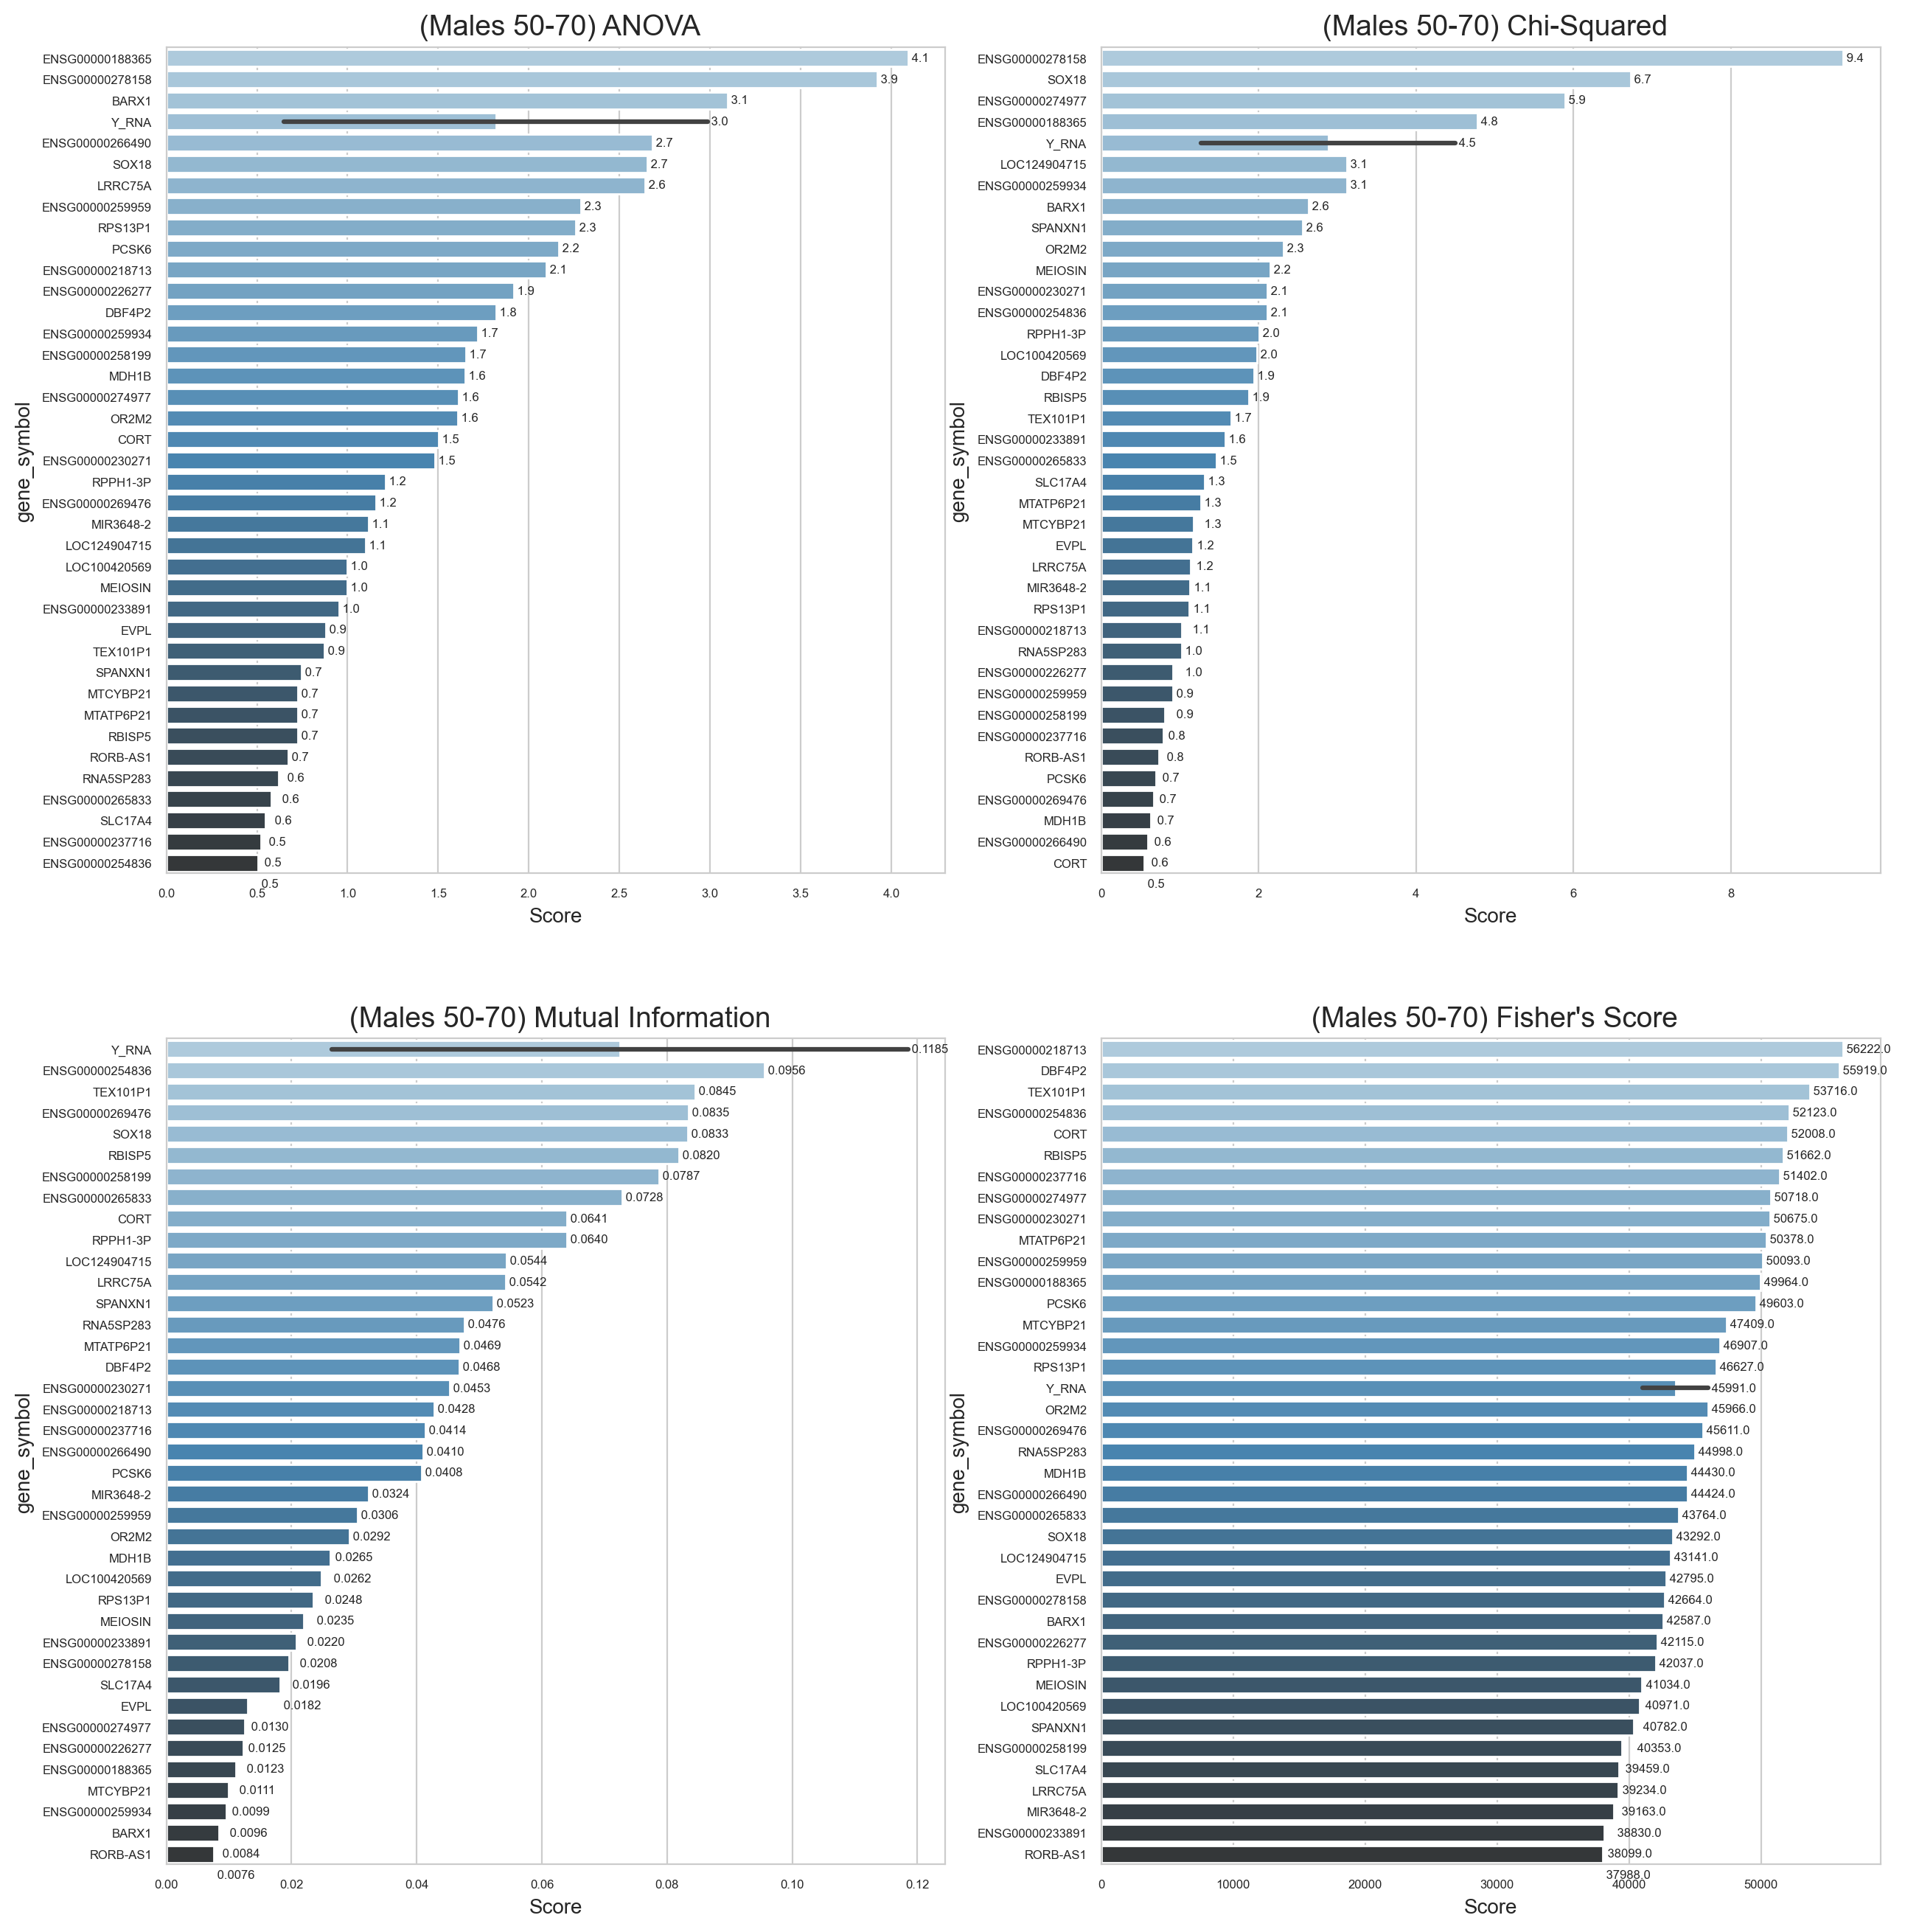

In [24]:
import seaborn as sns
plot_feature_importances(method_collection, consensus_genes.head(40), symbol_ensembl_mapping)

In [25]:
consensus_gene_symbols = symbol_ensembl_mapping[consensus_genes.index].to_frame()

### Enrichment of Consensus Genes

In [26]:
import gseapy as gp

In [28]:
enr = gp.enrichr(gene_list=consensus_gene_symbols['gene_symbol'].to_list(),
                 gene_sets=['MSigDB_Hallmark_2020',
                            'KEGG_2021_Human',
                            'WikiPathways_2024_Human',
                            'Human_Phenotype_Ontology',
                            'GO_Biological_Process_2025',
                            'GO_Molecular_Function_2025',
                            'GO_Cellular_Component_2025',
                            'SynGO_2024',
                            'OMIM_Disease'],
                 organism='human')

In [29]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TGF-beta Signaling,3/54,0.933167,0.999996,0,0,0.499622,3.455950e-02,CDH1;LTBP2;SMAD6
1,MSigDB_Hallmark_2020,Wnt-beta Catenin Signaling,2/42,0.944440,0.999996,0,0,0.424738,2.427947e-02,WNT6;HEY1
2,MSigDB_Hallmark_2020,Notch Signaling,1/32,0.971556,0.999996,0,0,0.274032,7.907602e-03,HES1
3,MSigDB_Hallmark_2020,Hedgehog Signaling,1/36,0.981779,0.999996,0,0,0.242660,4.462291e-03,HEY1
4,MSigDB_Hallmark_2020,Apical Surface,1/44,0.992524,0.999996,0,0,0.197426,1.481452e-03,GHRL
...,...,...,...,...,...,...,...,...,...,...
4098,OMIM_Disease,epilepsy,1/58,0.998427,0.999994,0,0,0.148818,2.342075e-04,SYN1
4099,OMIM_Disease,anemia,1/61,0.998874,0.999994,0,0,0.141354,1.592908e-04,SLC2A1
4100,OMIM_Disease,deafness,3/111,0.999576,0.999994,0,0,0.235179,9.973035e-05,CLDN14;PCDH15;DSPP
4101,OMIM_Disease,leukemia,1/78,0.999828,0.999994,0,0,0.110041,1.888650e-05,STAT5B


In [30]:
enr_res_pivot = enr.results.pivot(index='Term', columns='Genes', values='P-value')
enr_res_pivot = enr_res_pivot.fillna(1.0)

Text(0.5, 1.0, 'GSEA Results of Consensus Genes for Males Aged 50-70')

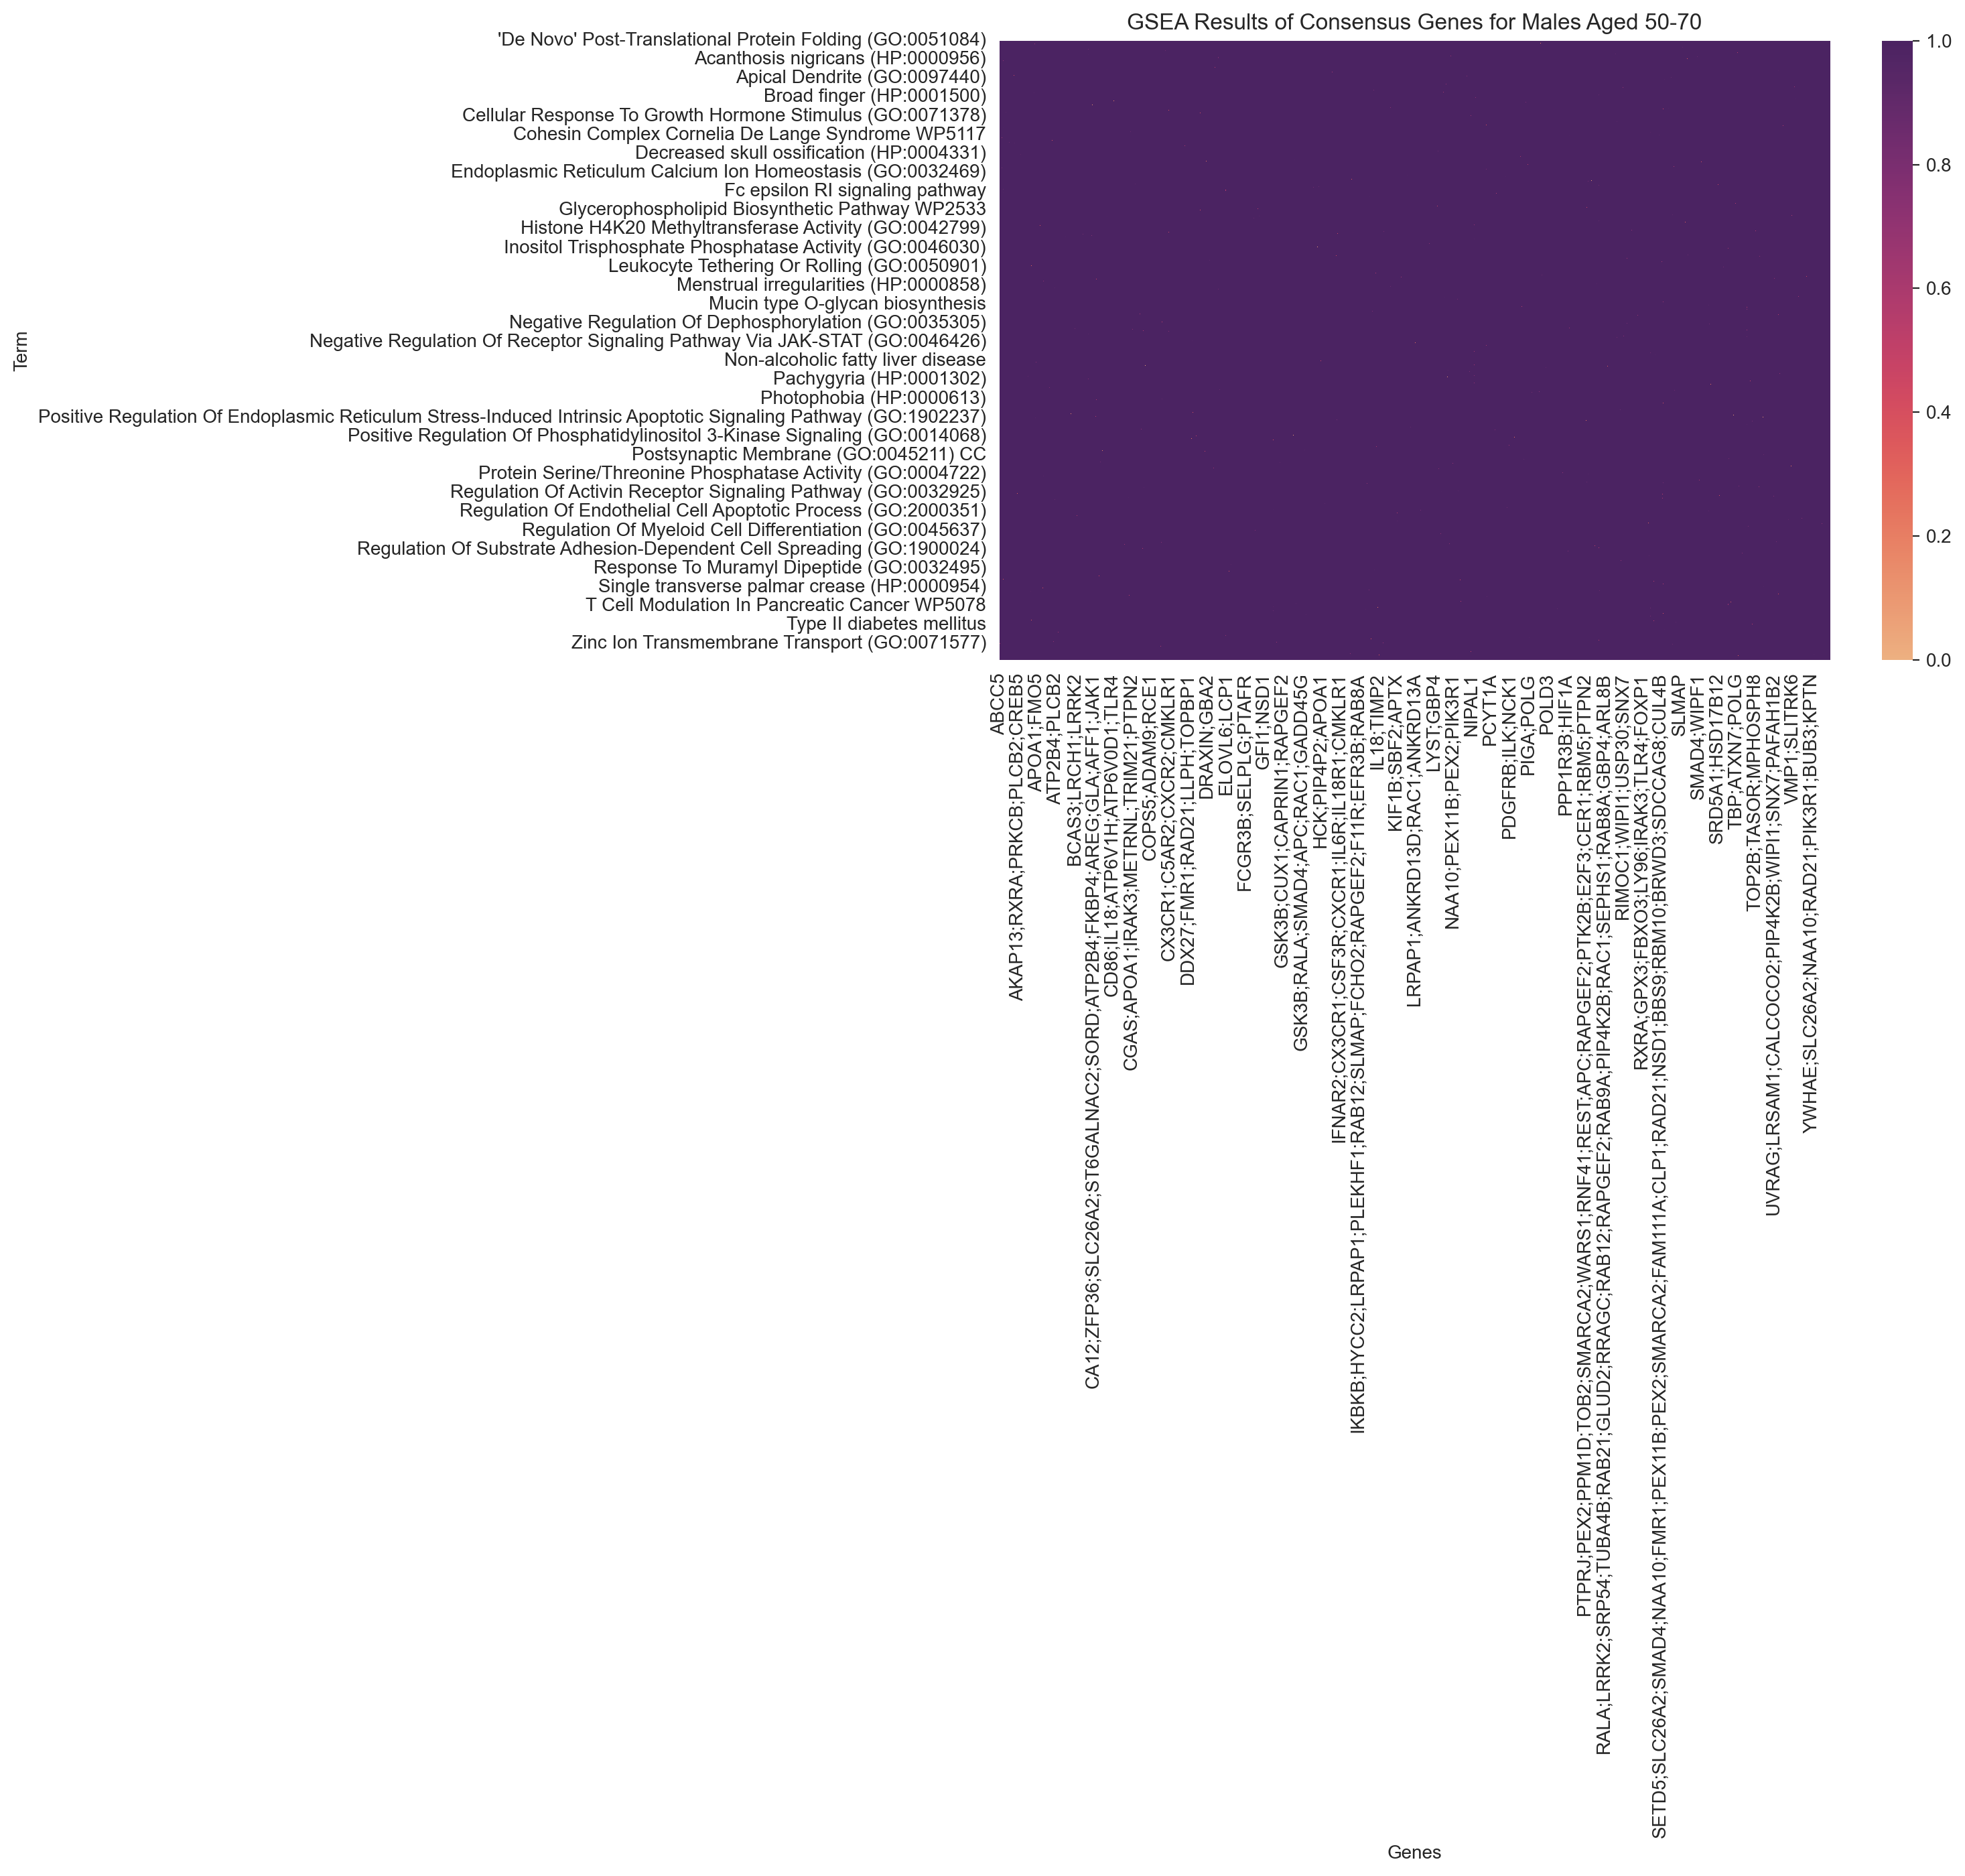

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    enr_res_pivot,
    cmap='flare',
    fmt='.3f',
    vmin=0, vmax=1
)
plt.title("GSEA Results of Consensus Genes for Males Aged 50-70")

In [30]:
symbol_ensembl_mapping.to_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_70-80.csv")